In this section, we will train the ViT model with the optimized settings identified from previous experiments with ViT models.
- learning rate = 0.0001
- cosine learning rate scheduler with warmup
- using the preprocessed image dataset whereby the hair noises are removed
- data augmentation (random horizontal filp, zoom, rotation, cropping)
- balanced class weight
- dropout with a probability of 0.5
- AdamW weight decay of 1e-2
- AdamW beta1 of 0.9 (default)
- AdamW beta2 of 0.99
- AdamW epsilon = 1e-8 (default)

The trained model is pushed to the
[hugging face hub](https://huggingface.co/sharren/vit-beta2-0.99/tree/main)

*Early stopping is employed: stop training if there is no improvement in the evaluation metric (in this case, decrease in validation loss) for 10 evaluation steps.*

# Dependencies and Libraries

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Installation

In [ ]:
#!pip install transformers
!pip install accelerate -U
# !pip install transformers[torch]
!pip install datasets
!pip install tensorboard
# !pip install wandb
#!pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
# install transformer from source
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-r5tqhg6l
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-r5tqhg6l
  Resolved https://github.com/huggingface/transformers.git to commit fadb053379b3ef24c4ec8e6d7d58555af21f58db
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.40.0.dev0-py3-none-any.whl size=8802765 sha256=4c259214c1c502c0a57d479dedd054949e8201c79cafa250f64ba85ddf39ce7e
  Stored in directory: /tmp/pip-ephem-wheel-cache-3x6p__4u/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


##Import

In [ ]:
import pandas as pd
from google.colab import userdata
import torch
from torch.utils.data import Dataset
import os
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image
import random
from torchvision.transforms import v2
from tqdm.notebook import tqdm
import shutil
from pathlib import Path
from datasets import load_dataset
from huggingface_hub import notebook_login
from tqdm.notebook import tqdm
# import wandb

# Load Dataset from Huggingface

In [ ]:
skin_dataset = load_dataset("sharren/processedSkin")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/5128 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2884 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2003 [00:00<?, ? examples/s]

In [ ]:
skin_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5128
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2884
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2003
    })
})

In [ ]:
labels = skin_dataset["train"].features["label"].names

idx2label = {idx: label for idx, label in enumerate(labels)}
label2idx = {label: idx for idx, label in enumerate(labels)}

In [ ]:
label2idx

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

# Processor


In [ ]:
from transformers import ViTImageProcessor
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224', do_rescale = False, return_tensors = 'pt')

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

# Transformation (With augmentation)

- flips horizontally with a probability of 0.5
- rotates the input image by a maximum angle of 10 degrees
- zooms into or out of the input image by a factor sampled uniformly from the range [1-0.1, 1+0.1]
- resizes the input image to a larger size, and then randomly crops a region of size 224x224 from the resized image

In [ ]:
# to apply what's in the default image processor along with the augmentation
image_mean, image_std = processor.image_mean, processor.image_std
normalize = v2.Normalize(mean=image_mean, std=image_std)

In [ ]:
from torchvision import transforms as v2
train_transform = v2.Compose([
    v2.Resize((processor.size["height"], processor.size["width"])),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.RandomResizedCrop(224),
    v2.ToTensor(),
    normalize
])

In [ ]:
test_transform = v2.Compose([
    v2.Resize((processor.size["height"], processor.size["width"])),
    v2.ToTensor(),
    normalize
])

In [ ]:
def train_transforms(examples):
    examples['pixel_values'] = [train_transform(image.convert("RGB")) for image in examples['image']]
    return examples

def test_transforms(examples):
    examples['pixel_values'] = [test_transform(image.convert("RGB")) for image in examples['image']]
    return examples

In [ ]:
# Set the transforms
skin_dataset['train'].set_transform(train_transforms)
skin_dataset['validation'].set_transform(test_transforms)
skin_dataset['test'].set_transform(test_transforms)

# Functions for Trainer

## Collate Function

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


## Compute Metrics Function

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(predictions, labels)
    precision = precision_score(labels, predictions, average='weighted',zero_division=0)
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}



A warning occur when training
`UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples`.
This warning commonly occurs in multi-class classification problems when some classes are not predicted by the model. It's often caused by class imbalance or the model's inability to adequately learn certain classes.



> To address this warning for the current stage, zero_division parameter is set in precision_score to specify the behavior when a class has no predicted samples.  Use a numeric value (in this case, 0) to use as the precision when the denominator is zero.




To further address the root cause which is class imbalance issue, we will use data augmentation in the later stage.

## Feature Extractor

In [ ]:
from transformers import ViTFeatureExtractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


# Model

In [ ]:
model_id = 'google/vit-base-patch16-224'

In [ ]:
import os
import shutil
import pandas as pd

os.chdir('/content/drive/MyDrive/FYP/data')

skin_df = pd.read_csv('HAM10000_metadata.csv')
df_labels = skin_df[['image_id', 'dx']].rename(columns={'dx': 'label'})
df_labels.head()

,image_id,label
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


In [ ]:
# Unmount Google Drive
from google.colab import drive
drive.flush_and_unmount()

# Change directory to default Colab directory
import os
os.chdir('/content')

# Verify current directory
print("Current directory:", os.getcwd())

Current directory: /content


In [ ]:
from transformers import ViTForImageClassification, ViTConfig

# Initialize a ViT base configuration
configuration = ViTConfig()

# No dropout initially
# Set dropout probabilities (adjust as needed)

configuration.attention_probs_dropout_prob = 0.5

# Set classification head
# configuration.num_labels=len(labels)
configuration.id2label={str(i): c for i, c in enumerate(labels)}
configuration.label2id={c: str(i) for i, c in enumerate(labels)}

# Instantiate the model with the custom configuration and classification head
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    config=configuration,
    ignore_mismatched_sizes=True,)
model.to(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Trainer

## Arguments

In [ ]:
epochs=100

Since early-stopping is employed, the total training steps calculated using the epochs may not be suitable, the total training steps will be extracted from the previous experiment using cosine scheduler which is 3852 (12 epochs)

In [ ]:
# total_training_steps = 3852
# warmup_steps = int(total_training_steps * 0.2) #0.05-0.2

In [ ]:
total_training_steps = 	8667 	#from dropout 0.5
warmup_steps = int(total_training_steps * 0.2) #0.05-0.2

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

args = TrainingArguments(
  output_dir="./vit-beta2-0.99",
  per_device_train_batch_size=16,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  logging_strategy="epoch",
  num_train_epochs=epochs,
  fp16=True,
  learning_rate= 0.0001,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
  metric_for_best_model="eval_loss", # early stopping criteria
  greater_is_better=False,
  lr_scheduler_type='cosine',
  warmup_steps=warmup_steps,
  lr_scheduler_kwargs={'num_cycles': 2},
  # logging_dir='logs', #tensorboard dir defaults to 'runs'

  weight_decay = 1e-2, #defaults to 0 [0, 0.1] (1e-5, 1e-4, 1e-3,1e-2)
  adam_beta1 = 0.9, #defaults to 0.9 [0.8, 0.99] (0.85, 0.88, 0.95)
  adam_beta2=0.99, #defaults to 0.999 [0.8, 0.999] (0.99, 0.995, 0.9995)
  # adam_epsilon=1e-08, #defaults to 1e-08  [1e-10, 1e-6] (1e-9,5e-09,1e-7)
)

AdamW hyperparameter
https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments
- weight_decay (float, optional, defaults to 0) — The weight decay to apply (if
not zero) to all layers except all bias and LayerNorm weights in AdamW optimizer.
- adam_beta1 (float, optional, defaults to 0.9) — The beta1 hyperparameter for the AdamW optimizer.
- adam_beta2 (float, optional, defaults to 0.999) — The beta2 hyperparameter for the AdamW optimizer.
- adam_epsilon (float, optional, defaults to 1e-8) — The epsilon hyperparameter for the AdamW optimizer.


## Custom Trainer: Loss function



**Loss Function**

For consistency among models, the compute_loss is overidden so that it is similar to CategoricalCrossentropy in Tensorflow

*EfficientNet and ResNet will be trained with Tensorflow framework*

## **Class Weight**

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
                                                  y=df_labels["label"])

In [ ]:
class_weights

array([ 4.37527304,  2.78349083,  1.30183284, 12.44099379,  1.28545758,
        0.21338021, 10.07545272])

In [ ]:
loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights))

In [ ]:
loss_fct.weight

tensor([ 4.3753,  2.7835,  1.3018, 12.4410,  1.2855,  0.2134, 10.0755],
       dtype=torch.float64)

In [ ]:
# Convert class weights to a tensor with the correct data type (Float)
# this is required to avoid error : expected scalar type Float but found Double
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
# for class weight
import torch
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor ).to('cuda')
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Apply Early Stopping



 The training will stop if there is no improvement in the evaluation metric (in this case, validation loss) for 10 evaluation steps.

In [ ]:
trainer = CustomTrainer(
    model,
    args,
    train_dataset=skin_dataset['train'],
    eval_dataset=skin_dataset['validation'],
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks=[EarlyStoppingCallback(10, 0.0)],
    # lr_scheduler=ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
    # optimizers=(optimizer, trainer.create_scheduler(total_training_steps)),
)

# Fine-tuning
We can now finetune our model by just calling the train method:

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.721700,1.019027,0.703537,0.663537,0.703537,0.652701
2,1.162200,0.738560,0.705617,0.757581,0.705617,0.719166
3,1.036800,0.655035,0.751734,0.756351,0.751734,0.721429
4,0.965300,0.564063,0.784327,0.794817,0.784327,0.786305
5,0.927200,0.795690,0.676838,0.795913,0.676838,0.703514
6,0.987800,0.580938,0.787101,0.806186,0.787101,0.790373
7,0.872000,0.681545,0.721567,0.808140,0.721567,0.744187
8,0.799800,0.610411,0.755895,0.814341,0.755895,0.772275
9,0.733000,0.529640,0.814840,0.825437,0.814840,0.817196
10,0.695700,0.579708,0.799584,0.832230,0.799584,0.805202


***** train metrics *****
  epoch                    =          28.0
  total_flos               = 10362927297GF
  train_loss               =        0.5275
  train_runtime            =    0:55:29.25
  train_samples_per_second =       154.028
  train_steps_per_second   =         9.642


*The train metrics are saved as train_results.json (assesible in the hub)*

# Evaluation on validation set

A good learning rate
-  leads to improved performance metrics such as accuracy, precision, recall, or F1-score on the validation set.

- promotes stable training, exihibiting a smooth decrease in loss over time

- results in a decreasing training loss without significant overfitting (validation loss remains low)

In [ ]:
metrics = trainer.evaluate(skin_dataset['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       28.0
  eval_accuracy           =     0.8623
  eval_f1                 =     0.8596
  eval_loss               =     0.5248
  eval_precision          =     0.8584
  eval_recall             =     0.8623
  eval_runtime            = 0:00:22.69
  eval_samples_per_second =    127.075
  eval_steps_per_second   =     15.906


In [ ]:
print(trainer.state)

TrainerState(epoch=28.0, global_step=8988, max_steps=32100, logging_steps=500, eval_steps=500, save_steps=500, train_batch_size=16, num_train_epochs=100, num_input_tokens_seen=0, total_flos=1.1127108458244538e+19, log_history=[{'loss': 1.7217, 'grad_norm': 27.36143684387207, 'learning_rate': 1.8291979226774382e-05, 'epoch': 1.0, 'step': 321}, {'eval_loss': 1.0190271139144897, 'eval_accuracy': 0.7035367545076283, 'eval_precision': 0.6635371340134015, 'eval_recall': 0.7035367545076283, 'eval_f1': 0.6527006206875058, 'eval_runtime': 22.7678, 'eval_samples_per_second': 126.67, 'eval_steps_per_second': 15.856, 'epoch': 1.0, 'step': 321}, {'loss': 1.1622, 'grad_norm': 32.75101089477539, 'learning_rate': 3.681477207155222e-05, 'epoch': 2.0, 'step': 642}, {'eval_loss': 0.7385604977607727, 'eval_accuracy': 0.705617198335645, 'eval_precision': 0.7575809849286596, 'eval_recall': 0.705617198335645, 'eval_f1': 0.7191659456414141, 'eval_runtime': 23.0256, 'eval_samples_per_second': 125.252, 'eval_st

In [ ]:
print(trainer.state.log_history)

[{'loss': 1.7217, 'grad_norm': 27.36143684387207, 'learning_rate': 1.8291979226774382e-05, 'epoch': 1.0, 'step': 321}, {'eval_loss': 1.0190271139144897, 'eval_accuracy': 0.7035367545076283, 'eval_precision': 0.6635371340134015, 'eval_recall': 0.7035367545076283, 'eval_f1': 0.6527006206875058, 'eval_runtime': 22.7678, 'eval_samples_per_second': 126.67, 'eval_steps_per_second': 15.856, 'epoch': 1.0, 'step': 321}, {'loss': 1.1622, 'grad_norm': 32.75101089477539, 'learning_rate': 3.681477207155222e-05, 'epoch': 2.0, 'step': 642}, {'eval_loss': 0.7385604977607727, 'eval_accuracy': 0.705617198335645, 'eval_precision': 0.7575809849286596, 'eval_recall': 0.705617198335645, 'eval_f1': 0.7191659456414141, 'eval_runtime': 23.0256, 'eval_samples_per_second': 125.252, 'eval_steps_per_second': 15.678, 'epoch': 2.0, 'step': 642}, {'loss': 1.0368, 'grad_norm': 7.780852317810059, 'learning_rate': 5.5337564916330066e-05, 'epoch': 3.0, 'step': 963}, {'eval_loss': 0.655035138130188, 'eval_accuracy': 0.751

In [ ]:
loss = []
for elem in trainer.state.log_history:
    if 'loss' in elem.keys():
        loss.append(elem['loss'])
print(loss)

[1.7217, 1.1622, 1.0368, 0.9653, 0.9272, 0.9878, 0.872, 0.7998, 0.733, 0.6957, 0.6271, 0.5614, 0.4576, 0.4645, 0.3913, 0.3693, 0.2794, 0.2677, 0.2104, 0.2459, 0.1769, 0.1294, 0.1597, 0.1227, 0.1054, 0.0945, 0.1242, 0.0819]


In [ ]:
print("Length of loss:", len(loss))

Length of loss: 28


In [ ]:
eval_loss = []
for elem in trainer.state.log_history:
    if 'eval_loss' in elem.keys():
        eval_loss.append(elem['eval_loss'])

eval_loss = eval_loss[:-1]
print(eval_loss)

[1.0190271139144897, 0.7385604977607727, 0.655035138130188, 0.5640625953674316, 0.7956904172897339, 0.580937922000885, 0.681545078754425, 0.6104105114936829, 0.5296399593353271, 0.579708456993103, 0.5925618410110474, 0.58785080909729, 0.6664562225341797, 0.5514557957649231, 0.5473943948745728, 0.5769267082214355, 0.5327965617179871, 0.5248246192932129, 0.6283748745918274, 0.6137195229530334, 0.5959635376930237, 0.5843542814254761, 0.6580309867858887, 0.6225888729095459, 0.6197877526283264, 0.6049804091453552, 0.6077802181243896, 0.6189650893211365]


In [ ]:
print("Length of eval_loss:", len(eval_loss))

Length of eval_loss: 28


### Loss curve



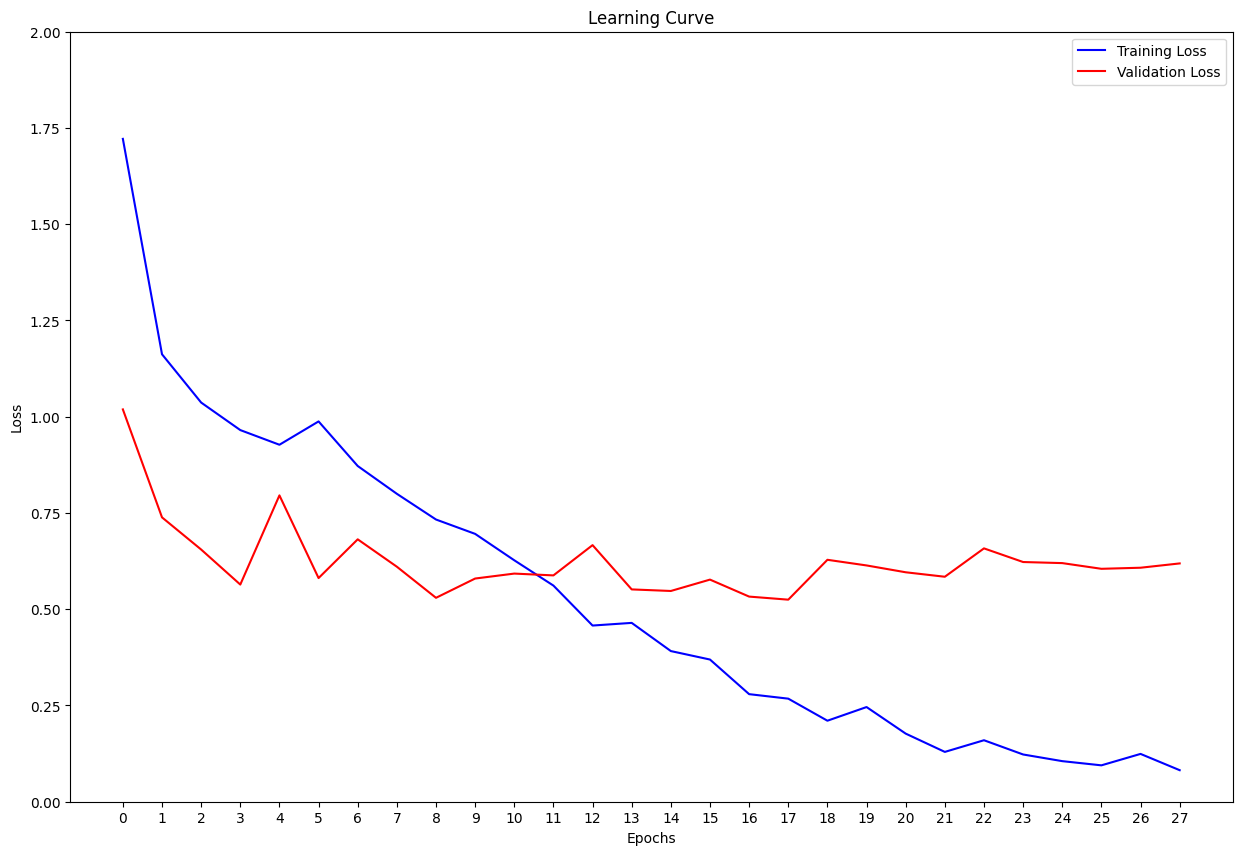

In [ ]:
import matplotlib.pyplot as plt

x_values = range(0, int(trainer.state.epoch), 1)
plt.figure(figsize=(15, 10))
plt.plot(x_values, loss, 'b-', label='Training Loss')
plt.plot(x_values, eval_loss, 'r-', label='Validation Loss')
plt.ylim(0,2)

plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0, int(trainer.state.epoch), 1))
plt.legend()

plt.show()


**Below is the learning curve before beta1 =  0.99 is applied: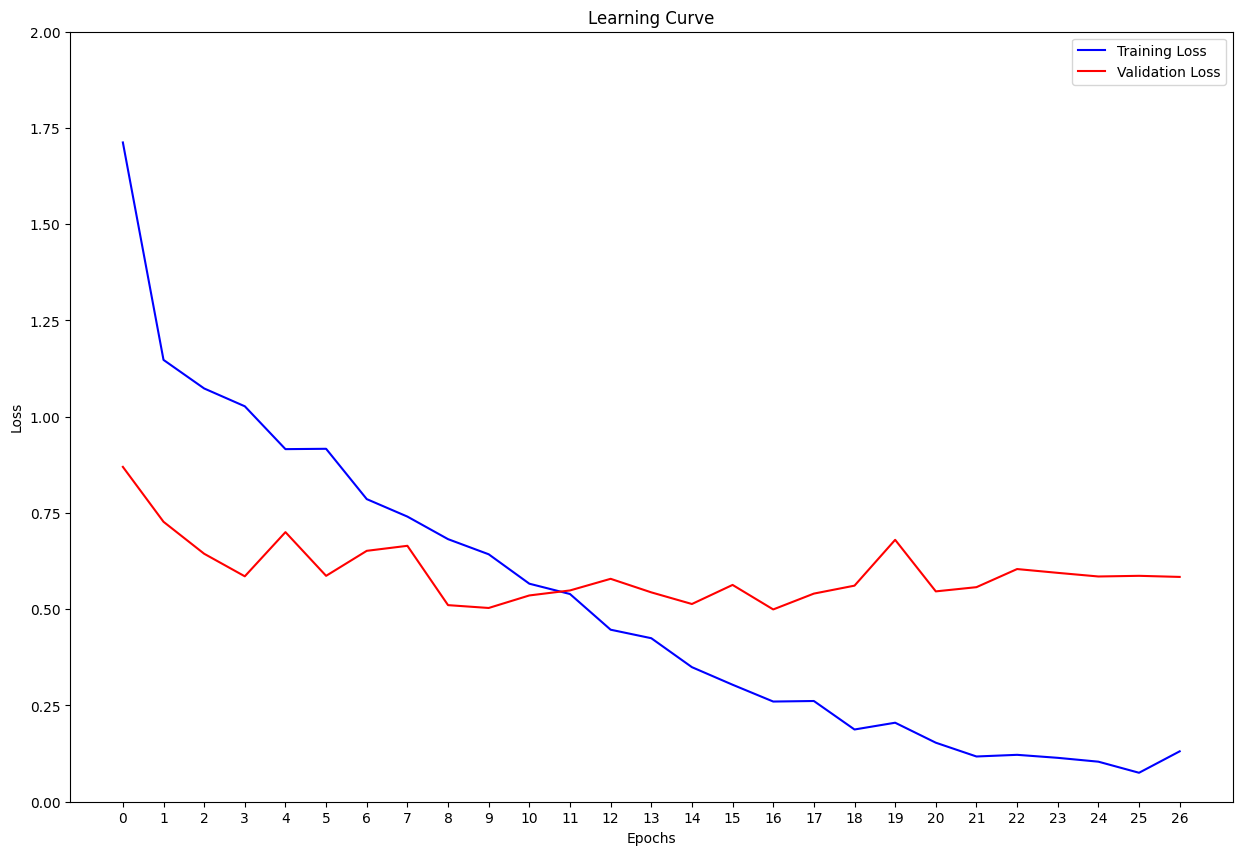**

## Tensorboard

From the tensorboard, it shows the plots for training loss over steps,validation loss over steps, validation accuracy, gradient norms.

A stable/converging model should show:
- Smooth decrease in loss over time, sudden jumps may indicate instability
- Increasing accuracy
- Gradual decrease in gradient norms (indicate convergence)


[Access Tensorboard](https://huggingface.co/sharren/vit-beta2-0.99/tensorboard)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir vit-beta2-0.99/runs/Mar22_07-40-30_80a90583e6d6

# Performance on Test Set

In [ ]:
outputs = trainer.predict(skin_dataset['test'])

In [ ]:
print(outputs.metrics)

{'test_loss': 0.5478606820106506, 'test_accuracy': 0.8582126809785322, 'test_precision': 0.8538092192616079, 'test_recall': 0.8582126809785322, 'test_f1': 0.8549718463126642, 'test_runtime': 16.089, 'test_samples_per_second': 124.495, 'test_steps_per_second': 15.601}


Comparing test performance of the current model using beta2 = 0.99 vs model using beta2 = 0.999 (1e-2 Weight Decay - ExptOverfit.ipynb)

In [ ]:
import pandas as pd

# Define the dictionaries containing the metrics
metrics_before = {
    'Metric': ['Test Loss', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1', 'Test Runtime', 'Test Samples/Second', 'Test Steps/Second'],
    'Value': [0.5128945708274841, 0.8517224163754369, 0.8516945393444719,
                 0.8517224163754369, 0.8514896537014855, 17.7983, 112.539, 14.102]
}

metrics_after = {
    'Metric': ['Test Loss', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1', 'Test Runtime', 'Test Samples/Second', 'Test Steps/Second'],
    'Value': [outputs.metrics['test_loss'], outputs.metrics['test_accuracy'], outputs.metrics['test_precision'],
              outputs.metrics['test_recall'], outputs.metrics['test_f1'], outputs.metrics['test_runtime'],
              outputs.metrics['test_samples_per_second'], outputs.metrics['test_steps_per_second']]
}

# Create pandas DataFrames
df_1 = pd.DataFrame(metrics_before)
df_2 = pd.DataFrame(metrics_after)

# Set Metric column as index for both DataFrames
df_1.set_index('Metric', inplace=True)
df_2.set_index('Metric', inplace=True)

# Concatenate DataFrames horizontally
df_combined = pd.concat([df_1, df_2], axis=1, keys=['Before', 'After'])

# Display the combined DataFrame
print(df_combined)


                         Before       After
                          Value       Value
Metric                                     
Test Loss              0.512895    0.547861
Test Accuracy          0.851722    0.858213
Test Precision         0.851695    0.853809
Test Recall            0.851722    0.858213
Test F1                0.851490    0.854972
Test Runtime          17.798300   16.089000
Test Samples/Second  112.539000  124.495000
Test Steps/Second     14.102000   15.601000


When compared to model using beta2 of 0.999, this model shows a
- Better test performance especially recall.
- Smoother decrease of grad norm. (in the tensorboard)
- Validation performances are comparable.

Therefore, beta2 = 0.99 is the optimal beta2

## Confusion Matrix



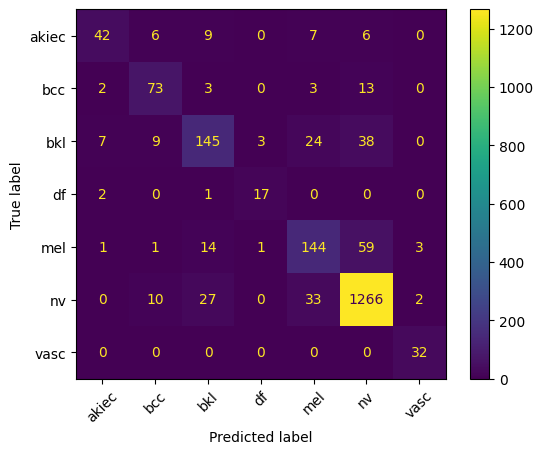

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = skin_dataset['train'].features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
# Assuming you have defined y_true and y_pred as mentioned before

# Calculate precision, recall, and F1-score for each class
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

# Create a DataFrame to store precision, recall, and F1-score for each class
metrics_per_class_df = pd.DataFrame({
    'Class': labels,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-score': f1_per_class
})

print(metrics_per_class_df)


   Class  Precision    Recall  F1-score
0  akiec   0.777778  0.600000  0.677419
1    bcc   0.737374  0.776596  0.756477
2    bkl   0.728643  0.641593  0.682353
3     df   0.809524  0.850000  0.829268
4    mel   0.682464  0.645740  0.663594
5     nv   0.916064  0.946188  0.930882
6   vasc   0.864865  1.000000  0.927536


# Push model to hub

In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'skin-cancer',
    "tags": ['image-classification'],
}

if args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

events.out.tfevents.1711096616.80a90583e6d6.2864.5:   0%|          | 0.00/560 [00:00<?, ?B/s]